In [1]:
!pip install ultralytics opencv-python-headless roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/12

In [2]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# 2. Install dependencies
!pip install ultralytics opencv-python-headless matplotlib scikit-learn seaborn

In [4]:
# Define your dataset path
dataset_path = "/content/drive/MyDrive/data"

In [5]:
import os
print("Classes:", os.listdir(dataset_path))

Classes: ['test', 'val', 'train', 'train.cache', 'val.cache', 'test_split']


In [6]:
import os

for split in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_path, split)
    print(f"\n📁 {split.upper()} SET:")
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len(os.listdir(cls_path))
        print(f"  🔸 Class '{cls}': {count} images")



📁 TRAIN SET:
  🔸 Class 'Non Accident': 422 images
  🔸 Class 'Accident': 369 images

📁 VAL SET:
  🔸 Class 'Non Accident': 52 images
  🔸 Class 'Accident': 46 images

📁 TEST SET:
  🔸 Class 'Non Accident': 54 images
  🔸 Class 'Accident': 47 images


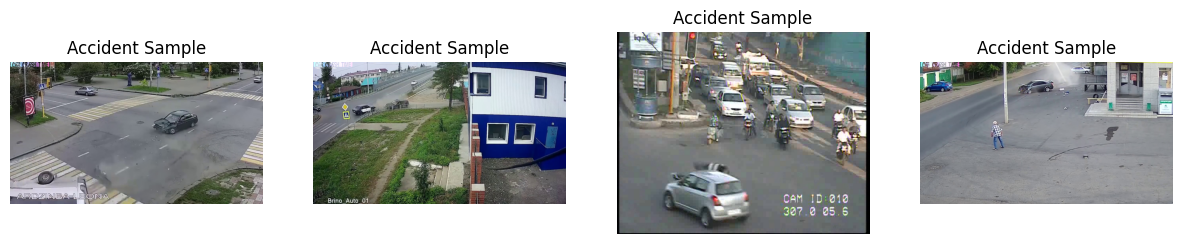

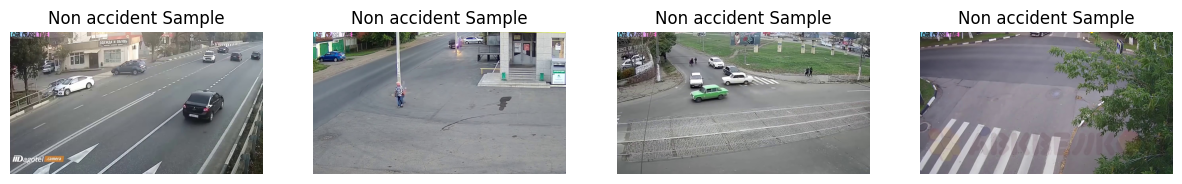

In [7]:
import matplotlib.pyplot as plt
import cv2
import random

def show_samples(split='train', cls='accident', n=4):
    img_dir = os.path.join(dataset_path, split, cls)
    img_files = random.sample(os.listdir(img_dir), n)

    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, img_file in enumerate(img_files):
        img_path = os.path.join(img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"{cls.capitalize()} Sample")
        axes[i].axis('off')
    plt.show()

show_samples('train', 'Accident')
show_samples('train', 'Non Accident')


BINARY CNN CLASSIFIER (Image Classification)

In [8]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm


In [9]:
# Basic transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset paths
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

# Load datasets
train_data = ImageFolder(train_dir, transform=transform)
val_data = ImageFolder(val_dir, transform=transform)
test_data = ImageFolder(test_dir, transform=transform)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)


Classes: ['Accident', 'Non Accident']


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classification
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


In [11]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

def evaluate_model(model, loader):
    model.eval()
    total, correct = 0, 0
    loss_total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_total += criterion(outputs, labels).item()
    return loss_total / len(loader), correct / total

train_model(model, criterion, optimizer, num_epochs=10)


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


Epoch 1/10 - Train Loss: 0.5023, Val Loss: 0.2001, Val Acc: 0.8878


100%|██████████| 25/25 [00:15<00:00,  1.67it/s]


Epoch 2/10 - Train Loss: 0.1819, Val Loss: 0.1505, Val Acc: 0.9286


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Epoch 3/10 - Train Loss: 0.0852, Val Loss: 0.1278, Val Acc: 0.9184


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Epoch 4/10 - Train Loss: 0.0623, Val Loss: 0.1085, Val Acc: 0.9184


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Epoch 5/10 - Train Loss: 0.0480, Val Loss: 0.1223, Val Acc: 0.9286


100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


Epoch 6/10 - Train Loss: 0.0382, Val Loss: 0.1380, Val Acc: 0.9388


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Epoch 7/10 - Train Loss: 0.0410, Val Loss: 0.1570, Val Acc: 0.9388


100%|██████████| 25/25 [00:15<00:00,  1.59it/s]


Epoch 8/10 - Train Loss: 0.0186, Val Loss: 0.1090, Val Acc: 0.9490


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Epoch 9/10 - Train Loss: 0.0166, Val Loss: 0.2660, Val Acc: 0.9082


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Epoch 10/10 - Train Loss: 0.0131, Val Loss: 0.1797, Val Acc: 0.9388


In [12]:
test_loss, test_acc = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0708, Test Accuracy: 0.9700


In [13]:
torch.save(model.state_dict(), "cnn_accident_classifier.pth")


Fine-Tuning YOLOv5 on this Accident Dataset

In [14]:
# train yolov5 as classifier
!pip install ultralytics
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [15]:
from ultralytics import YOLO

# Load classification model (s version)
model = YOLO('yolov8s-cls.pt')  # For classification tasks

# Train the classifier
model.train(
    data="/content/drive/MyDrive/data",  # path to folder containing train/val
    epochs=10,
    imgsz=224,
    device=0 if torch.cuda.is_available() else 'cpu',
    batch=32
)


100%|██████████| 12.3M/12.3M [00:00<00:00, 47.7MB/s]

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/data, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False, s

100%|██████████| 5.35M/5.35M [00:00<00:00, 169MB/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:271: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:280: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Co

AMP: checks passed ✅
train: Fast image access ✅ (ping: 1.6±1.8 ms, read: 36.5±29.5 MB/s, size: 84.6 KB)


train: Scanning /content/drive/MyDrive/data/train... 791 images, 0 corrupt: 100%|██████████| 791/791 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 1.2±0.9 ms, read: 33.3±30.7 MB/s, size: 145.7 KB)


val: Scanning /content/drive/MyDrive/data/val... 98 images, 0 corrupt: 100%|██████████| 98/98 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/10      1.15G     0.7087         32        224:   8%|▊         | 2/25 [00:02<00:27,  1.21s/it]


100%|██████████| 755k/755k [00:00<00:00, 92.6MB/s]
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

                   all      0.796          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 24.15it/s]

                   all      0.816          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 28.55it/s]

                   all      0.878          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 24.83it/s]

                   all      0.765          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 41.19it/s]

                   all      0.918          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 33.60it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 17.86it/s]

                   all      0.888          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 22.10it/s]

                   all      0.918          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 19.57it/s]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      10/10      1.17G     0.1712         23        224: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 26

                   all      0.918          1



10 epochs completed in 0.048 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/train/weights/best.pt, 10.3MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:271: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:280: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

YOLOv8s-cls summary (fused): 30 layers, 5,077,762 parameters, 0 gradients, 12.4 GFLOPs
train: /content/drive/MyDrive/data/train... found 791 images in 2 classes ✅ 
val: /content/drive/MyDrive/data/val... found 98 images in 2 classes ✅ 
test: /content/drive/MyDrive/data/test... found 100 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


                   all      0.929          1
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8861c4d650>
curves: []
curves_results: []
fitness: 0.9642857015132904
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9285714030265808, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9642857015132904}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.1288706020441354, 'inference': 0.8501444693913109, 'loss': 0.00032309183747461896, 'postprocess': 0.00046981632777362613}
task: 'classify'
top1: 0.9285714030265808
top5: 1.0

In [16]:
metrics = model.val(data="/content/drive/MyDrive/data/test")
print(metrics)


Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,077,762 parameters, 0 gradients, 12.4 GFLOPs
WARNING ⚠️ Dataset 'split=train' not found at /content/drive/MyDrive/data/test/train
Found 100 images in subdirectories. Attempting to split...
Splitting /content/drive/MyDrive/data/test (2 classes, 101 images) into 80% train, 20% val...
Split complete in /content/drive/MyDrive/data/test_split ✅
train: /content/drive/MyDrive/data/test_split/train... found 79 images in 2 classes ✅ 
val: /content/drive/MyDrive/data/test_split/val... found 21 images in 2 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 91.0±35.0 MB/s, size: 235.1 KB)


val: Scanning /content/drive/MyDrive/data/test_split/val... 21 images, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


                   all      0.952          1
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f87825adf10>
curves: []
curves_results: []
fitness: 0.9761904776096344
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9523809552192688, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9761904776096344}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.07958714286360191, 'inference': 2.203437857144222, 'loss': 0.0005703333326458786, 'postprocess': 0.007450857137449756}
task: 'classify'
top1: 0.9523809552192688
top5: 1.0



image 1/1 /content/drive/MyDrive/data/test/Accident/test_33.jpg: 224x224 Accident 1.00, Non Accident 0.00, 4.9ms
Speed: 17.2ms preprocess, 4.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
ultralytics.engine.results.Probs object with attributes:

data: tensor([0.9989, 0.0011], device='cuda:0')
orig_shape: None
shape: torch.Size([2])
top1: 0
top1conf: tensor(0.9989, device='cuda:0')
top5: [0, 1]
top5conf: tensor([0.9989, 0.0011], device='cuda:0')


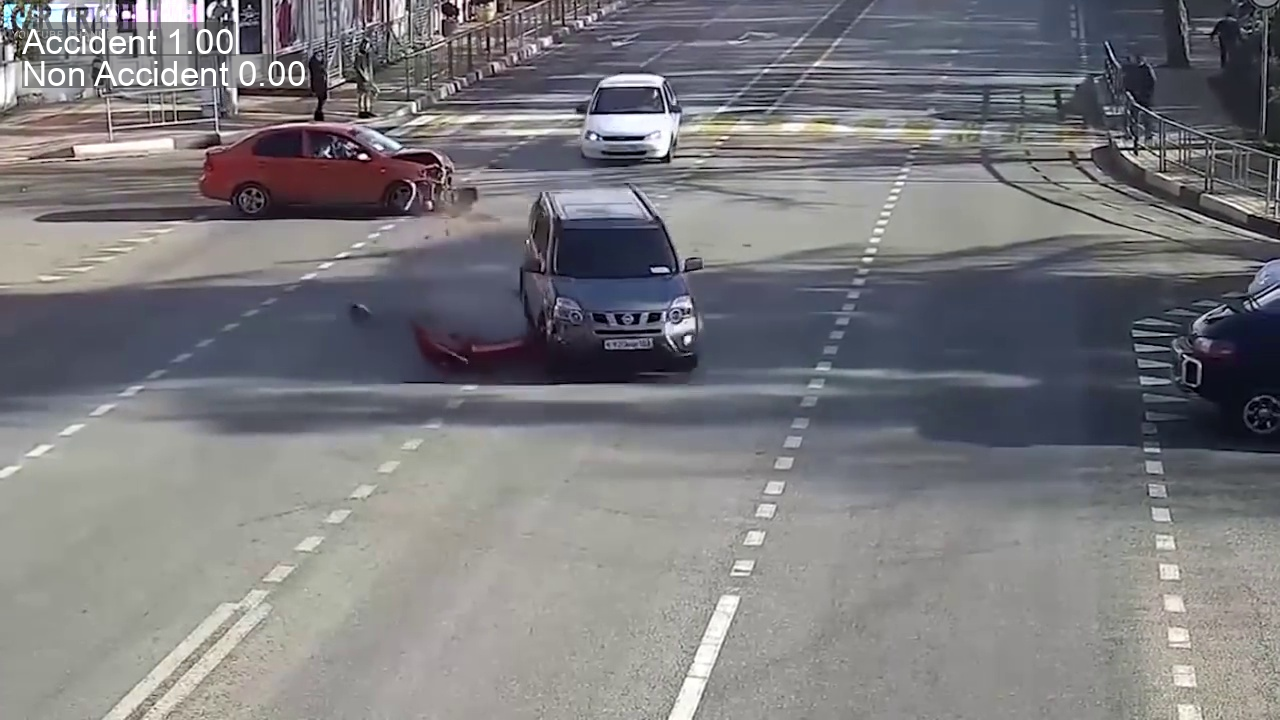

In [17]:
results = model("/content/drive/MyDrive/data/test/Accident/test_33.jpg")
print(results[0].probs)  # Probability per class
results[0].show()


In [18]:
model.export(format='onnx')  # Optional: for deployment
model.save("safevision_yolo_classifier.pt")


Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 2) (9.8 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 11.6s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 13.6s, saved as 'runs/classify/train/weights/best.onnx' (19.4 MB)

Export complete (13.8s)
Results saved to /content/runs/classify/train/weights
Predict:         yolo predict task=classify model=runs/classify/train/weights/best.onnx imgsz=224  
Validate:        yo

Real-Time CCTV Simulation + Classification

In [20]:
video_path = "/content/drive/MyDrive/accident_footage2.mp4"

In [22]:
from ultralytics import YOLO
import cv2
import torch

# Load the trained classification model
model = YOLO("safevision_yolo_classifier.pt")

# Class mapping
class_names = ['Accident', 'Non Accident']


In [43]:
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output
import time

def simulate_realtime_classification_colab(video_path, threshold=0.85):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_count > 200:  # Limit to first 200 frames
            break

        resized = cv2.resize(frame, (224, 224))
        results = model(resized, verbose=False)
        probs = results[0].probs.data.tolist()
        pred_class = class_names[probs.index(max(probs))]
        confidence = max(probs)

        # Display using matplotlib
        label = f"{pred_class.upper()} ({confidence:.2f})"
        color = (0, 0, 255) if pred_class == 'accident' else (0, 255, 0)
        frame = cv2.putText(frame, label, (30, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)

        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.title(label)
        plt.axis('off')
        plt.show()

        # 🚨 Trigger alert
        if pred_class == 'accident' and confidence >= threshold:
            send_alert(label)
            time.sleep(3)  # delay to avoid spamming

        frame_count += 1
        time.sleep(0.1)  # simulate ~10 FPS

        log_detection(frame_count, pred_class, confidence)

    cap.release()



Emergency Alert System

In [44]:
import smtplib
from email.mime.text import MIMEText

def send_alert(msg="🚨 Accident Detected!"):
    sender_email = "samartha.2021@vitstudent.ac.in"
    receiver_email = "msushasamu@gmail.com"
    app_password = "Samartha100%"  # Use Gmail app password here

    message = MIMEText(msg)
    message["Subject"] = "🚨 SafeVision Alert"
    message["From"] = sender_email
    message["To"] = receiver_email

    try:
        with smtplib.SMTP("smtp.gmail.com", 587) as server:
            server.starttls()
            server.login(sender_email, app_password)
            server.sendmail(sender_email, receiver_email, message.as_string())
        print("Alert sent successfully!")
    except Exception as e:
        print(f"Failed to send alert: {e}")


In [45]:
simulate_realtime_classification_colab("accident_footage2.mp4")

SMS Alets using Twilio

In [36]:
!pip install twilio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.7 MB/s eta 0:00:00


In [37]:
from twilio.rest import Client

def send_sms_alert(body="🚨 Accident Detected by SafeVision!"):
    account_sid = 'ACba9045e75db4ecb60466a01ecfca1c1a'
    auth_token = 'f2c5116ba9c5e36aac8aabed1fb8adbf'
    client = Client(account_sid, auth_token)

    message = client.messages.create(
        from_='+18507896838',
        to='+919845398988',
        body=body
    )

    print("✅ SMS sent:", message.sid)


In [38]:
from twilio.rest import Client

# Twilio config
account_sid = 'ACba9045e75db4ecb60466a01ecfca1c1a'
auth_token = 'f2c5116ba9c5e36aac8aabed1fb8adbf'
twilio_number = "+18507896838"      # Your Twilio number
target_number = "+919845398988"     # Your verified mobile number

client = Client(account_sid, auth_token)

def send_sms_alert(msg="🚨 Accident Detected!"):
    try:
        message = client.messages.create(
            body=msg,
            from_=twilio_number,
            to=target_number
        )
        print(f"SMS sent: SID={message.sid}")
    except Exception as e:
        print(f"SMS send failed: {e}")


Record Predictions to a CSV and saving it

In [40]:
import csv
import os
from datetime import datetime

log_file = "detection_log.csv"

# Create and write header if it doesn't exist
if not os.path.exists(log_file):
    with open(log_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["timestamp", "frame", "class", "confidence"])

def log_detection(frame_num, pred_class, confidence):
    with open(log_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([datetime.now(), frame_num, pred_class, confidence])
